# 輪郭の階層情報
## 目的
ここでは輪郭の階層情報(輪郭における親子関係)を学ぶ．

## 理論
これまで輪郭に関する幾つかのチュートリアルを通してOpenCVが提供する輪郭関連の関数の使い方を学んできた． [cv2.findContours()](http://docs.opencv.org/3.0-beta/modules/imgproc/doc/structural_analysis_and_shape_descriptors.html?highlight=cv2.findcontours#findcontours) 関数の第２引数 _Contour Retrieval Mode_ に対して，普通は `cv2.RETR_LIST` か `cv2.RETR_TREE` を設定するとうまく輪郭検出が得られた．しかし，これらのフラグはいったい何を意味しているのだろうか？

また，三番目の出力である 階層情報(hierarchy) があった．この「階層情報」とは何なのだろうか、輪郭検索モードのフラグとどのような関係にあるのだろうか？

このチュートリアルでは上記のトピックを扱う．


## 階層情報とは何か？
画像中の物体検出のために [cv2.findContours()](http://docs.opencv.org/3.0-beta/modules/imgproc/doc/structural_analysis_and_shape_descriptors.html?highlight=cv2.findcontours#findcontours) 関数を使ってきた。そこでは図形はいろいろな場所に位置していた。時にはある図形の中に別の図形が入ってたりする(入れ子図形のような関係)ことがあった．このような場合、外側に位置するものを 親(parent) と呼び，内側に位置するものを 子(child) と呼ぶ．このように，画像の輪郭が互いに何らかの関係にある場合がある．そしてある輪郭が別の輪郭とどのような関係にあるか記述することができる：この輪郭は他の輪郭の子か、それとも親か、など。このような関係を表す表現のことを__階層情報__と言う．

次の画像を例に考えてみよう :
![](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/_images/hierarchy.png)

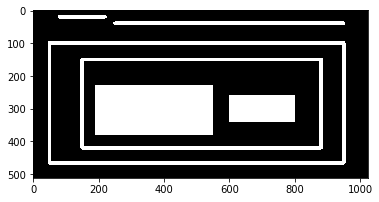

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Create a black image
img = np.zeros((512,1024,3), np.uint8)

# 0 
cv2.line(img,(80,20),(220,20),(255,255,255),10)
# 1 
cv2.line(img,(250,40),(950,40),(255,255,255),10)
# 2
cv2.rectangle(img,(50,100),(950,465),(255,255,255),10)
#3 
cv2.rectangle(img,(150,150),(880,420),(255,255,255),10)
# 4
cv2.rectangle(img,(190,230),(550,380),(255,255,255),-1)
# 5
cv2.rectangle(img,(600,260),(800,340),(255,255,255),-1)

plt.imshow(img,'gray')

この画像には 0-5 の番号をつけた図形がある． そして2 と 2a はそれぞれ一番外側の箱の「外」と「内」を表している．

ここで、輪郭0,1,2は __最外部(external)__とか__外側(outermost)__ と呼ばれ， __hierarchy-0__ に属するとか、単に __同じ階層レベル(same hierarchy level)__にあると言う．

輪郭2a は輪郭2の__子__とみなせる(逆にいえば、輪郭2が輪郭2aの__親__とも言える)。したがって、輪郭2aは __hierarchy-1__ となる（親がhierarchy-__0__なので子は__1__)。同様に，輪郭3は輪郭2の「子」であり，これは次の階層(hierarchy-__2__)に位置することになる．最後に輪郭4,5はcontour-3aの子であり、最後の階層レベルに位置する(質問: これらはhierachyの何番目か？)ここで輪郭の番号付け規則に従えば，輪郭4は輪郭3aの「__最初の子__」と呼べよう（ただし、方法によっては輪郭5が「最初の子」となることもある）．

以上は __同じ階層レベル, 最外部の輪郭, 子の輪郭, 親の輪郭, 最初の子__ という用語を説明するためのものであった．ここからは、OpenCVの解説に入っていくことにする．



## OpenCVの階層表現
輪郭それぞれは固有の情報として，どの階層に属しているか，自分の子や親がどれか、などの情報を保持している．これをOpenCVでは4つの値からなる配列(array)として `[Next, Previous, First_Child, Parent] `と表現している．

__"Nextは同一階層レベルに属する次の輪郭を表す．”__

例えば，上記の輪郭0であれば，同一レベルの次の輪郭は輪郭1を指すので， `Next = 1` となる．同様に，輪郭1の次の輪郭は輪郭2なので Next = 2 となる．

それでは輪郭2のNextはどうなるだろうか?同一階層にはこれ以上輪郭がないため，` Next = -1 `となる．また、輪郭4のNextは輪郭5となるため Next = 5 となる．

__“Previousは同一階層レベルの一つ前の輪郭を表す．”__

PreviousはNextの逆である．輪郭1のPreviousは輪郭0であり，輪郭2のPreviousは輪郭1である．そして，輪郭0にとって前の輪郭は存在しないため，Previousは`-1`となる．

__“First_Child はその輪郭の最初の子要素を表す．”__

説明するまでもなく，輪郭2のFirst_Childは輪郭2aのインデックスになる．それでは輪郭3aのFirst_Childはどうなるだろうか?二つの子要素を持っているがFirst_Childはあくまでも最初の子要素のみを表すため，(今回の例では左から順番をつけたため) `First_Child = 4` となる．

__“Parent はその輪郭の親要素のインデックスを表す．”__

Parentは __First_Child__ の逆である．輪郭4と輪郭5の親要素は輪郭3aであり，輪郭3aの親要素は輪郭3である．

<font color="blue">Note</font>: 子要素や親要素がなければ値は-1である．

これでOpenCVで使われる階層構造を理解できたので，次は同じ画像を使ってOpenCVの輪郭検出法についてみていくことにする．具体的には`cv2.RETR_LIST, cv2.RETR_TREE, cv2.RETR_CCOMP, cv2.RETR_EXTERNAL`といったフラグが何を意味するのか学ぶことにしよう．

## 輪郭検出モード
### 1. RETR_LIST
RETR_LISTは4つのフラグの中で(説明のし易さを考えると)最も単純なものである．このフラグを使うと全ての輪郭を検出するが，輪郭の親子関係は無視される． __このルールの下では親要素も子要素も同等に扱われ，いずれも単なる輪郭として解釈される__．つまり，全ての輪郭が同一階層に属すことになる．

したがって、この条件では3番目と4番目の値が常に―1となり，NextとPreviousには対応するインデックスが格納されることになる．自分で試して確認してみること．

以下に私が実験した結果を示す．各行が一つの輪郭に対応している．例えば，1行目は輪郭0を表しており，次の輪郭が輪郭1であるため、１行目では`Next = 1`となっている．また，輪郭0の「前の輪郭」は無いので`Previous = 0`である．前述したように，残りの2つの数値は-1となる．



```
>>> hierarchy
array([[[ 1, -1, -1, -1],
        [ 2,  0, -1, -1],
        [ 3,  1, -1, -1],
        [ 4,  2, -1, -1],
        [ 5,  3, -1, -1],
        [ 6,  4, -1, -1],
        [ 7,  5, -1, -1],
        [-1,  6, -1, -1]]])
```

In [19]:
img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(img_gray, 127, 255,0)
_, contours,hierarchy = cv2.findContours(thresh,cv2.RETR_LIST,1)
hierarchy

array([[[ 1, -1, -1, -1],
        [ 2,  0, -1, -1],
        [ 3,  1, -1, -1],
        [ 4,  2, -1, -1],
        [ 5,  3, -1, -1],
        [ 6,  4, -1, -1],
        [ 7,  5, -1, -1],
        [-1,  6, -1, -1]]], dtype=int32)

階層に関する特徴を使わないのであればこのモードを選択すると良いだろう．

### 2. RETR_EXTERNAL
RETR_EXTERNALを使うと，全部の子要素は無視され、最も外側の輪郭のみが返される． __このルールの下では，親子関係のうち最も祖先に相当する(最も外側の)輪郭だけが残り，その他の輪郭は無視される．__

例にあげた画像においては最も外側の輪郭，すなわち階層レベルが0の輪郭は何個あるだろうか?答えはたったの3個，つまり輪郭0，1，2である．それでは、このフラグを使って実際に輪郭検出をしてみよう．そしてRETR_LISTを使った結果と比較してみよう:

```
>>> hierarchy
array([[[ 1, -1, -1, -1],
        [ 2,  0, -1, -1],
        [-1,  1, -1, -1]]])
```
最も外側の輪郭のみを検出したい時にこのフラグを使う．

In [21]:
img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(img_gray, 127, 255,0)
_, contours,hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL,1)
hierarchy

array([[[ 1, -1, -1, -1],
        [ 2,  0, -1, -1],
        [-1,  1, -1, -1]]], dtype=int32)

### 3. RETR_CCOMP
RETR_CCOMPは全輪郭を検出し，2種類の階層に分類する：階層1は物体の外側の輪郭、階層2は物体の内側の穴などの輪郭である．物体の中に物体がある場合は，その物体は階層1となり，その穴は階層2となる．

黒地に白く書かれた0を想像してみよう．0の外側の円は第一の階層，内側の円は第二の階層に属すことになる．

次の画像を例として考えよう．輪郭のインデックスを赤色で，その輪郭が属す階層を緑色で書いてある．なおこのインデックスはOpenCVが検出する輪郭の順番と同じようになっている．
![](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/_images/ccomp_hierarchy.png)

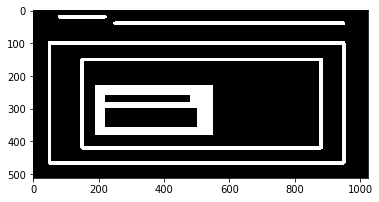

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Create a black image
img = np.zeros((512,1024,3), np.uint8)

# 8
cv2.line(img,(80,20),(220,20),(255,255,255),10)
# 7 
cv2.line(img,(250,40),(950,40),(255,255,255),10)
# 5
cv2.rectangle(img,(50,100),(950,465),(255,255,255),10)
# 3 
cv2.rectangle(img,(150,150),(880,420),(255,255,255),10)
# 0
cv2.rectangle(img,(190,230),(550,380),(255,255,255),-1)
# 1
cv2.rectangle(img,(220,260),(480,280),(0,0,0),-1)
# 2
cv2.rectangle(img,(220,300),(500,355),(0,0,0),-1)

plt.imshow(img,'gray')

まず輪郭0は階層1に属している．輪郭0が持つ2つの穴、郭1と輪郭2はどちらも階層2に属している．輪郭0の同一階層レベルの次の輪郭は輪郭3であり，前の輪郭は存在しない．First_Childは階層2に属する輪郭1で，Parentは存在しない．結果として，輪郭0の階層配列は`[3,-1,1,-1]`となる．

次に輪郭1を見てみよう．そのNextは同一階層に属している(輪郭1のParentの下で)輪郭2である．前の輪郭，子要素はなく、親は輪郭0である．結果として，階層配列は`[2,-1,-1,0]`となる．

同様に輪郭2は階層2であり，Nextはなく，Previousは輪郭1である．子要素はなく，親は0となるため階層配列は`[-1,1,-1,0]`となる．

階層1に属す輪郭3のNextは輪郭5，Previousは輪郭0，Childは輪郭4となり，Parentはない．よって，階層配列は`[5,0,4,-1]`となる．

輪郭3の下の階層2に属す輪郭4は、同一階層に輪郭がないため，NextもPreviousも―1となる．子要素もないが，Parentは輪郭3なので，階層配列は`[-1,-1,-1,3]`となる．

他の輪郭については自分で考えてみよう．関数を使って得られた結果は以下のようになる:


```
>>> hierarchy
array([[[ 3, -1,  1, -1],
        [ 2, -1, -1,  0],
        [-1,  1, -1,  0],
        [ 5,  0,  4, -1],
        [-1, -1, -1,  3],
        [ 7,  3,  6, -1],
        [-1, -1, -1,  5],
        [ 8,  5, -1, -1],
        [-1,  7, -1, -1]]])
```

In [28]:
img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(img_gray, 127, 255,0)
_, contours,hierarchy = cv2.findContours(thresh,cv2.RETR_CCOMP,1)
hierarchy

array([[[ 3, -1,  1, -1],
        [ 2, -1, -1,  0],
        [-1,  1, -1,  0],
        [ 5,  0,  4, -1],
        [-1, -1, -1,  3],
        [ 7,  3,  6, -1],
        [-1, -1, -1,  5],
        [ 8,  5, -1, -1],
        [-1,  7, -1, -1]]], dtype=int32)

## 4. RETR_TREE
これが最後のフラグである．全輪郭を検出し，全階層情報を保持する． __家系図における祖父，父，息子，孫，...と全情報を保持する...__ :)．

例えば，先の画像に対し`cv2.RETR_TREE`により得られた結果に基づき輪郭のインデックス及び階層のインデックスを描いた図は以下となる．

![CCOMP Hierarchy](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/_images/tree_hierarchy.png)

輪郭0は階層0に属し、次の輪郭は同一階層内の輪郭7となる．前の輪郭はなく，子要素は輪郭1である．親要素は無いため，階層配列は`[7,-1,1,-1]`となる．

輪郭2は階層1となり，同一階層には他に輪郭がないため，Next, previousは共に$-1$となる．Childは輪郭2，Parentは輪郭0となるため，階層配列は`[-1,-1,2,0]`である．

RETR_CCOMPの例と同様，その他の輪郭については自分で計算してみよう．下に関数を使って得られた結果を示す:

```
>>> hierarchy
array([[[ 7, -1,  1, -1],
        [-1, -1,  2,  0],
        [-1, -1,  3,  1],
        [-1, -1,  4,  2],
        [-1, -1,  5,  3],
        [ 6, -1, -1,  4],
        [-1,  5, -1,  4],
        [ 8,  0, -1, -1],
        [-1,  7, -1, -1]]])
        ```

In [29]:
img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(img_gray, 127, 255,0)
_, contours,hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,1)
hierarchy

array([[[ 7, -1,  1, -1],
        [-1, -1,  2,  0],
        [-1, -1,  3,  1],
        [-1, -1,  4,  2],
        [-1, -1,  5,  3],
        [ 6, -1, -1,  4],
        [-1,  5, -1,  4],
        [ 8,  0, -1, -1],
        [-1,  7, -1, -1]]], dtype=int32)

## 目次
* [最初に戻る]( http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/Notebook/usingOpenCV.html )
* [OpenCVにおける輪郭(領域)]( http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/Notebook/contours.html)
* 前の学習項目: [輪郭に関するいろいろな関数 contourMoreFunctions.ipynb](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/Notebook/contourMoreFunctions.html)<BR>
凸性の欠陥（convexity defects）， 多角形近似のテスト，形状のマッチング等について学ぶ．
* 次の学習項目:  [OpenCVでのヒストグラム](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/Notebook/histogram.html) 
ヒストグラムについて学ぶ．